In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import sem

# Visualization Tools
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Test/Train Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

import my_functions

In [3]:
MSSubClasses = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45:	'1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75:	'2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85:	'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
    120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    150: '1-1/2 STORY PUD - ALL AGES',
    160: '2-STORY PUD - 1946 & NEWER',
    180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}

# To-Do's

- Import data
    - Search for features with highest correlation to Sale Price
- Clean data
    - [Normalize](https://developers.google.com/machine-learning/data-prep/transform/normalization) features + target variable
    - Deal with features with null values
    - Deal with features with outliers
- Multi-Linear Regression
    - Perform it once and check mean squared regression
    - [Use bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) and try again


In [4]:
df = pd.read_csv('data/train.csv')

In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

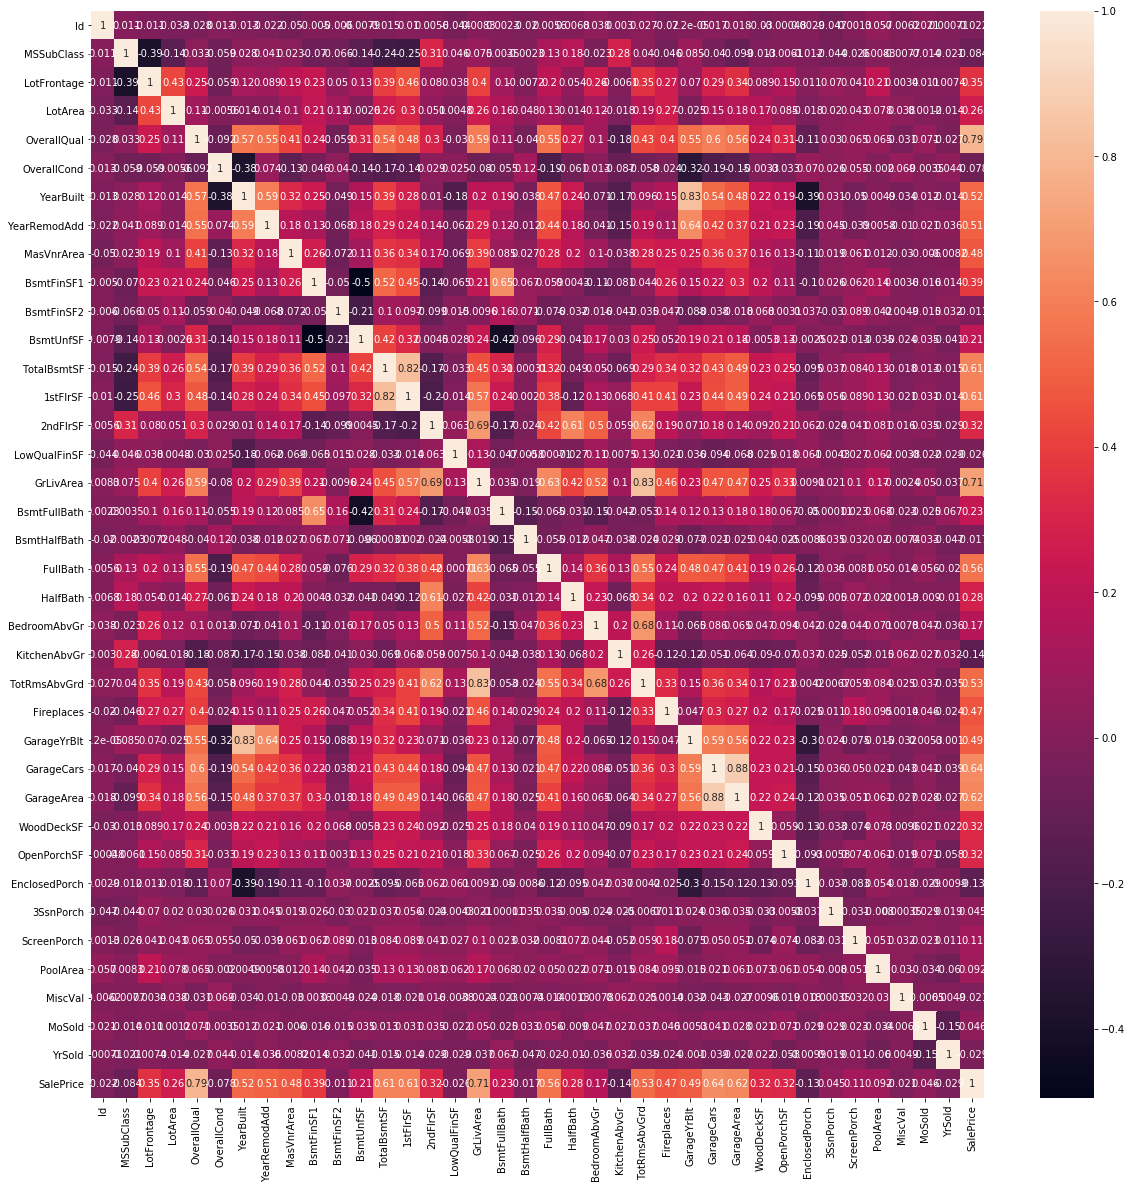

In [6]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True)

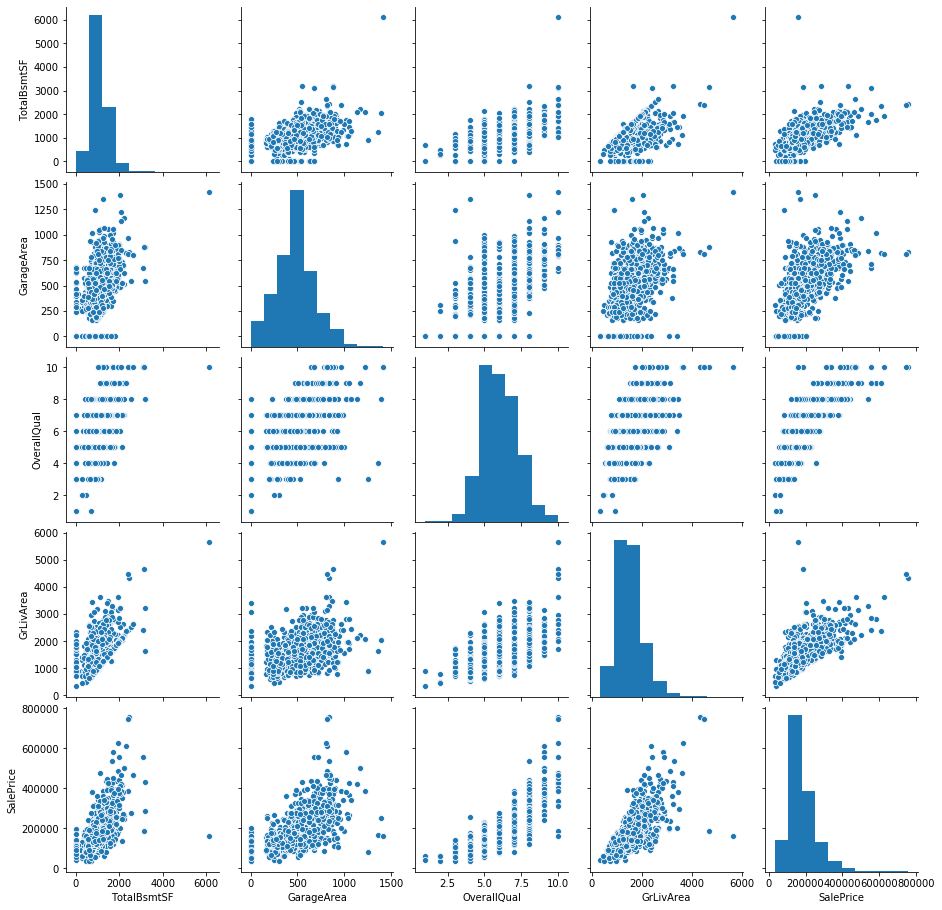

In [7]:
sns.pairplot(df.loc[:, ['TotalBsmtSF', 'GarageArea', 'OverallQual', 'GrLivArea', 'SalePrice']])

## Cleaning

I'll use the following normalization techniques for the corresponding features (note: don't scale the target variable, as it doesn't affect the shape of the linear regression function):

- Z-Score
    - Fields: `TotalBsmtSF`, `GrLivArea`
    - X' = (X - mean) / std
    - Has some outliers, but not extreme
- Linear Scaling
    - Fields: `OverallQual`, `GarageArea`
    - X' = (X - X_min) / (X_max - X_min)
    - Distribution is more-or-less uniformly distributed

In [8]:
# Reshapre Features if non-linear relationship

In [9]:
# Normalize Features
for field in ['TotalBsmtSF', 'GrLivArea', 'SalePrice']:
    df[field + '_norm'] = (df[field] - df[field].mean()) / df[field].std()

for field in ['OverallQual', 'GarageArea']:
    df[field + '_norm'] = (df[field] - df[field].min()) / (df[field].max() - df[field].min())

In [10]:
# Remove Outliers


## Linear Regression

In [11]:
feature_columns = [
    'TotalBsmtSF_norm', 
    'OverallQual_norm', 
    'GrLivArea_norm', 
    # 'GarageArea_norm'
]
X = df.loc[:, feature_columns]
y = df['SalePrice']

X['OverallQual_norm**2'] = X['OverallQual_norm'].apply(lambda x: x**2)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('Train RMSE: {:,.2f}'.format(math.sqrt(mean_squared_error(y_train, y_train_pred))))
print('Test RMSE: {:,.2f}'.format(math.sqrt(mean_squared_error(y_test, y_test_pred))))

Train RMSE: 40,281.80
Test RMSE: 30,792.54


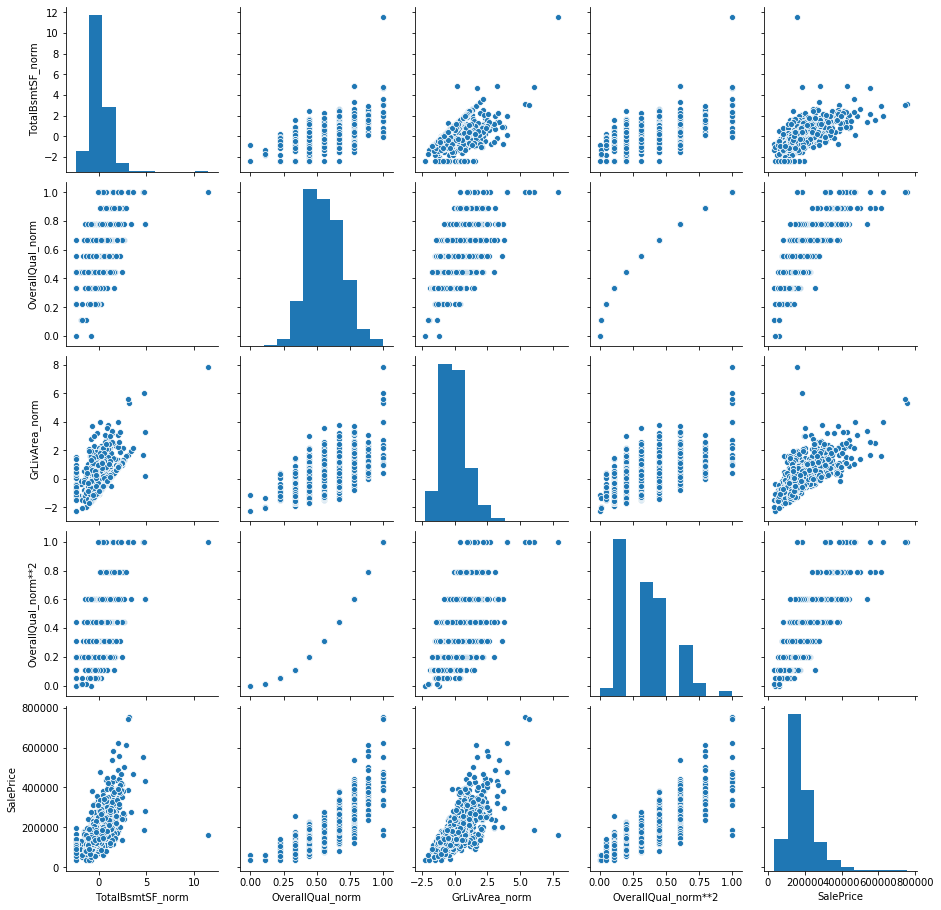

In [14]:
sns.pairplot(pd.concat([X.loc[:, feature_columns + ['OverallQual_norm**2']], y], axis=1))

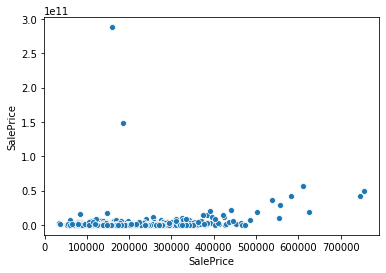

In [15]:
sns.scatterplot(x=y_train, y=(y_train_pred-y_train)**2)

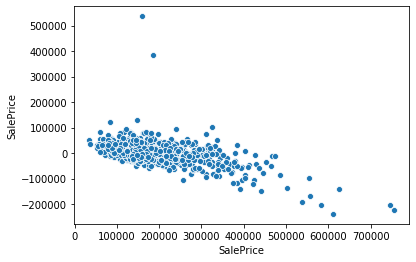

In [16]:
sns.scatterplot(x=y_train, y=(y_train_pred-y_train))